# Классичесское машинное обучение

## Место для импорта библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier

In [2]:
CATEGORICAL_COLUMNS = ['geography', 'gender']
RANDOM_SEED = 123

## Загрузка и предобработка данных

Общая информация: 

Вам дана таблица bank_clients_data.csv содержащая данные о клиентах банка.<br>Необходимо решить задачу классификации, покинул клиент банк или нет. <br>
Поля таблицы:

* RowNumber — соответствует номеру записи (строки)
* СustomerId — id клиента;
* Surname — фамилия клиента;
* CreditScore — крдитный рейтиинг клиента, полученный в результате каких-то расчетов внутри банка;
* Geography — местоположение клиента;
* Gender — пол;
* Age — возраст;
* Tenure — количество лет, в течение которых человек является клиентом банка;
* Balance — остаток на счете;
* NumOfProducts — количество продуктов, которые клиент приобрел через банк;
* HasCrCard — есть ли у клиента кредитная карта. 1-да, 0-нет;
* IsActiveMember — активный-1 или нет-2 клиент;
* EstimatedSalary — заработная плата;
* Exited — перестал ли клиент пользоваться услугами банка и в принципе быть его лкиентом. Целевая переменная. Характеризует отток.


In [3]:
df = pd.read_csv('bank_clients_data.csv', index_col=0)

In [4]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
df.columns = ['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   credit_score      10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            10000 non-null  int64  
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [8]:
df.is_active_member.value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

Значения колонки не совпадают с описанием выше, будем считать что данные введены верно и 0 - это не активный клиент, а 1 - активный. 

In [9]:
df.duplicated().sum()

0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   surname           10000 non-null  object 
 2   credit_score      10000 non-null  int64  
 3   geography         10000 non-null  object 
 4   gender            10000 non-null  object 
 5   age               10000 non-null  int64  
 6   tenure            10000 non-null  int64  
 7   balance           10000 non-null  float64
 8   num_of_products   10000 non-null  int64  
 9   has_cr_card       10000 non-null  int64  
 10  is_active_member  10000 non-null  int64  
 11  estimated_salary  10000 non-null  float64
 12  exited            10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


## 1. EDA. Составьте Общее представление о данных

#### 1. Прочитайте таблицу и выведите информацию о каждом столбце (среднее значение, среднее отклонение, основные процентили итп)

In [11]:
df.describe()

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### 2. Чему равен 80% процентиль по полю зарплаты, результат округлите до 1 знака после запятой, о чём говорит данное значение?

In [12]:
round(float(df.estimated_salary.quantile([0.8])), 1)
#Говорит о том, что 20% самых высоких зарплат начинаются с 159836.7

159836.7

#### 3. Есть ли в данных пропущенные значения?

In [13]:
df.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

In [14]:
# Проверим на неявные пропуски
for col in ['geography', 'gender']:
    print(df[col].value_counts())

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64
Male      5457
Female    4543
Name: gender, dtype: int64


Пропусков в данных не найдено.

#### 4. Проверьте сбалансированность классов и сделайте вывод 


In [15]:
class_counts = df['exited'].value_counts()
class_ratios = class_counts / len(df)

print("Количество образцов по классам:")
print(class_counts)
print("\nДоли классов:")
print(class_ratios)

Количество образцов по классам:
0    7963
1    2037
Name: exited, dtype: int64

Доли классов:
0    0.7963
1    0.2037
Name: exited, dtype: float64


Классы не сбалансированы.

## 2. Построение графиков 

#### 1. Постройте гистограмму распределения возраста клиентов, сделайте ее зеленого цвета, не забудьте про наименования осей и самого графика

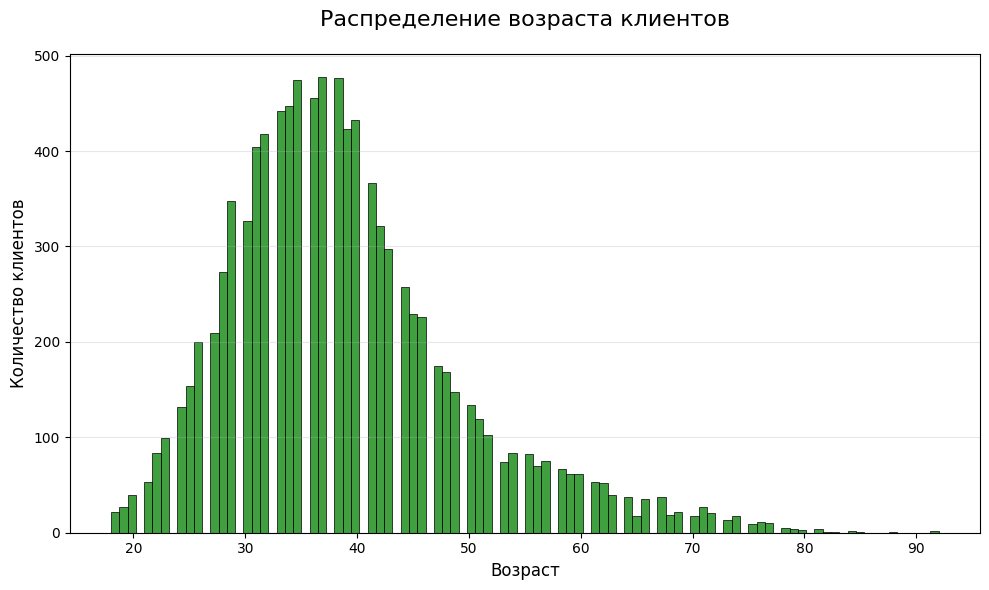

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', color='green', bins=100)
plt.title('Распределение возраста клиентов', fontsize=16, pad=20)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### 2. Постройте график распределения количества ушедших клиентов исходя из их пола. Наверху каждого столбца отобразите количественный показатель. Какой можно сделать вывод?

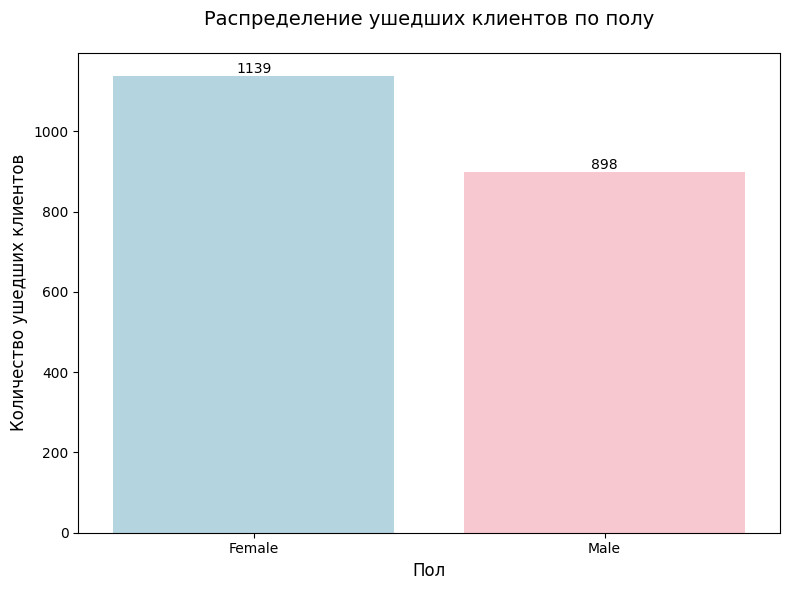

In [17]:
exited_customers = df[df['exited'] == 1]
gender_counts = exited_customers['gender'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=['lightblue', 'pink'])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.title('Распределение ушедших клиентов по полу', fontsize=14, pad=20)
plt.xlabel('Пол', fontsize=12)
plt.ylabel('Количество ушедших клиентов', fontsize=12)

plt.tight_layout()
plt.show()

Перед тем как делать выводы о количестве ушедших исходя из пола посмотрим на общий баланс классов.

In [18]:
df.gender.value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [19]:
#Вывод: присутствует гендерный дисбаланс в оттоке клиентов. Даже учитывая что общее количество мужчин больше в данных, их уходит меньше.

#### 3. Возьмите данные о географии клиентов и их доходах. Постройте круговую диаграмму, отображающую картину среднего заработка по странам (должны быть видны страны и конкретные числовые значения)

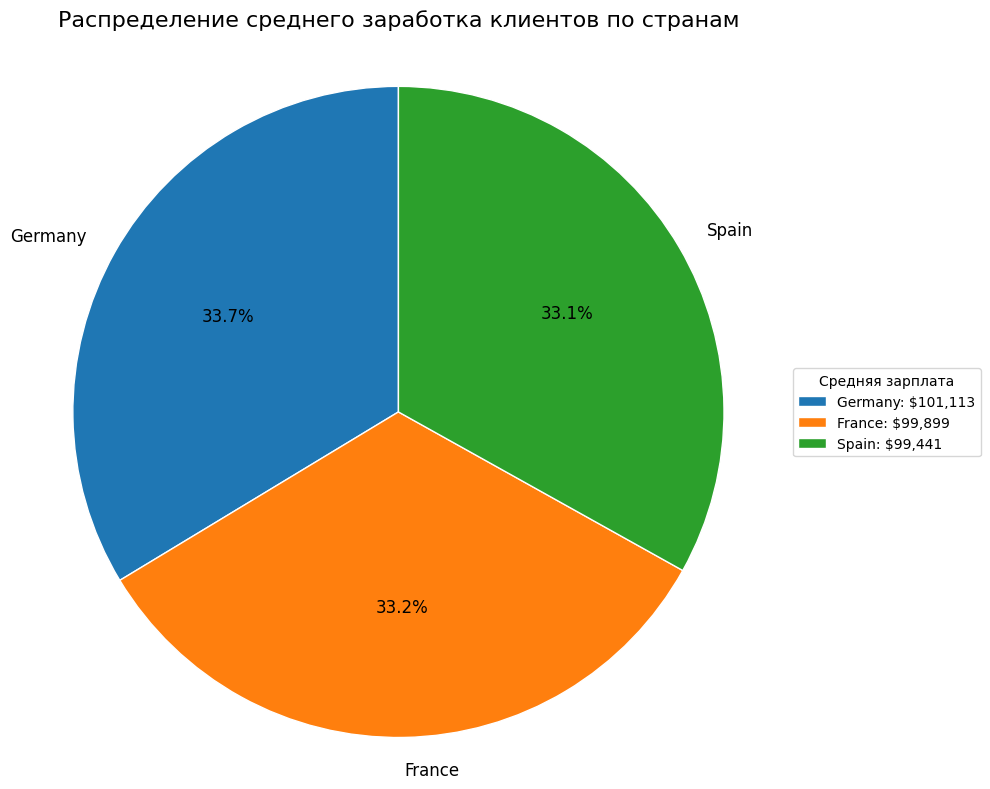

In [20]:
country_salary = df.groupby('geography')['estimated_salary'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
plt.pie(country_salary, 
        labels=country_salary.index, 
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 12})
legend_labels = [f"{country}: ${salary:,.0f}" 
                for country, salary in zip(country_salary.index, country_salary)]
plt.legend(legend_labels, 
          title="Средняя зарплата", 
          loc="center left", 
          bbox_to_anchor=(1, 0.5))
plt.title('Распределение среднего заработка клиентов по странам', pad=20, fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

#### 4. Постройте тепловую карту корреляции всех признаков из таблицы. Согласно полученной карте, какие признаки показывают наибольшую взаимосвязь? 

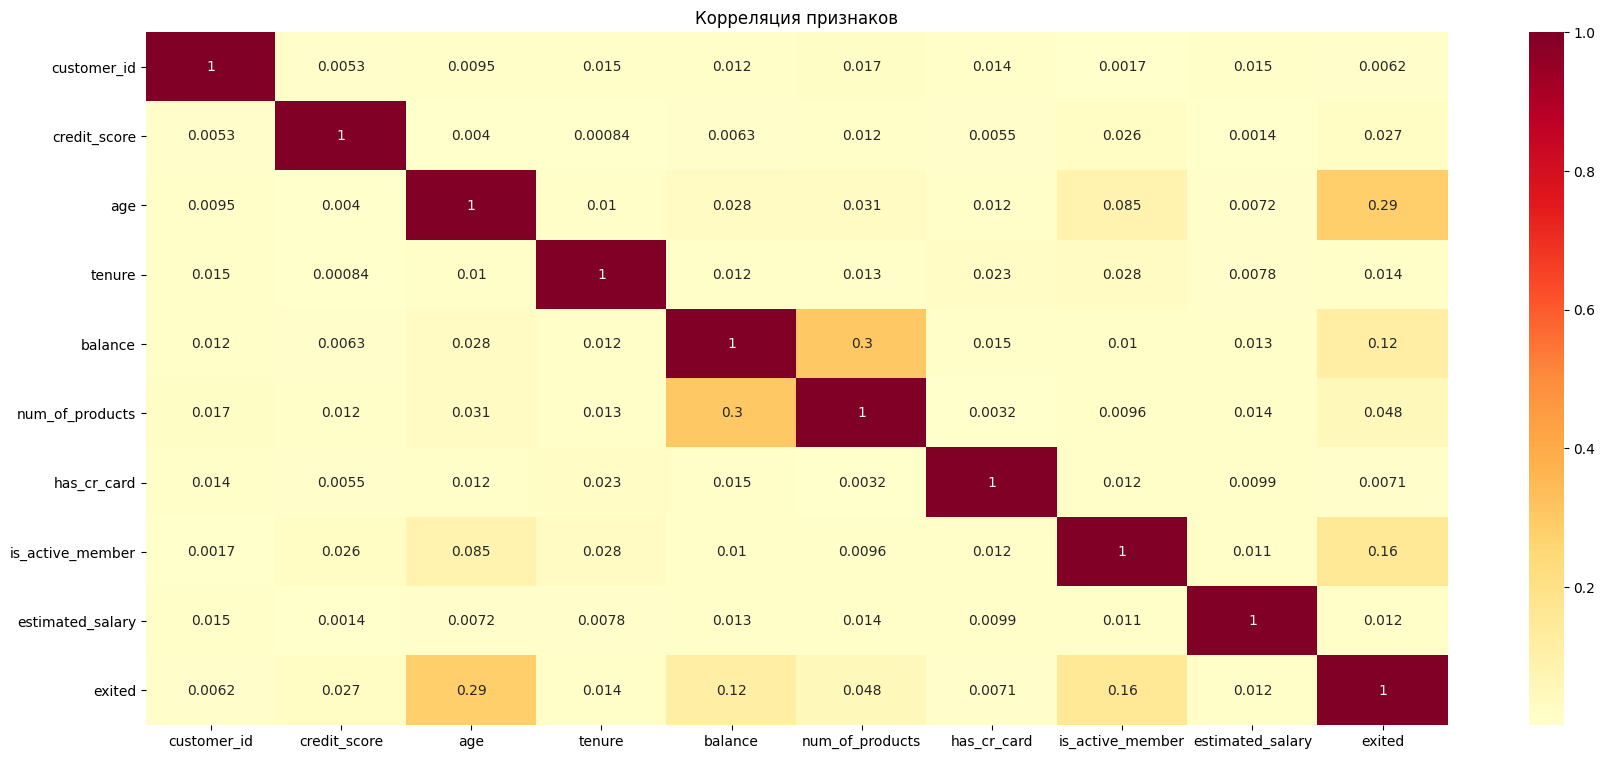

In [21]:
plt.figure(figsize=(21,9))
sns.heatmap(df.drop(['surname', 'geography', 'gender'], axis=1).corr().abs(), cmap='YlOrRd', annot=True)
plt.title('Корреляция признаков')
plt.show()

Больше всего с целевым признаком exited коррелируют 'age', 'balanse', 'is_active_number'.
Между собой признаки коррелируют не сильно.
Целевой признак age имеет корреляцию больше 0.1 только с полем exited.

## 3. Подготовка данных к использованию в алгоритмах ml

####  1. Избавьтесь от полей, которые по вашему мнению являются неинформативными, поясните выбор

In [22]:
# Ни айди пользователя ни его фамилия не дают никакой информации для моделей
df.drop(['surname', 'customer_id'], inplace=True, axis=1)

#### 2. Переведите категориальные данные в числовые. 

Сделаем 2 кодировки: OHE для линейных и OE нелинейных моделей.

In [23]:
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_features = ohe.fit_transform(df[CATEGORICAL_COLUMNS])

ohe_feature_names = ohe.get_feature_names_out(CATEGORICAL_COLUMNS)
df_ohe = pd.DataFrame(ohe_features, columns=ohe_feature_names, index=df.index)

df_for_linear = df.drop(CATEGORICAL_COLUMNS, axis=1)
df_for_linear = pd.concat([df_for_linear, df_ohe], axis=1)

df_for_linear.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2,0.00,1,1,1,101348.88,1,0.0,0.0,0.0
2,608,41,1,83807.86,1,0,1,112542.58,0,0.0,1.0,0.0
3,502,42,8,159660.80,3,1,0,113931.57,1,0.0,0.0,0.0
4,699,39,1,0.00,2,0,0,93826.63,0,0.0,0.0,0.0
5,850,43,2,125510.82,1,1,1,79084.10,0,0.0,1.0,0.0


In [24]:
oe = OrdinalEncoder() 
df[CATEGORICAL_COLUMNS] = oe.fit_transform(df[CATEGORICAL_COLUMNS])

df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
RowNumber,,,,,,,,,,,
1,619,0.0,0.0,42,2,0.00,1,1,1,101348.88,1
2,608,2.0,0.0,41,1,83807.86,1,0,1,112542.58,0
3,502,0.0,0.0,42,8,159660.80,3,1,0,113931.57,1
4,699,0.0,0.0,39,1,0.00,2,0,0,93826.63,0
5,850,2.0,0.0,43,2,125510.82,1,1,1,79084.10,0


#### 3. Разделите данные на train (80%) и test (20%) любым способом

1. Для задачи линейной регрессии, целевой признак Age<br> Получите датасеты:
X_reg_train, X_reg_test, y_reg_train, y_reg_test

2. Для задачи логистической регрессии. Целевой признак Exited<br> Получите датасеты:
X_cl_train, X_cl_test, y_cl_train, y_cl_test

In [25]:
X_lin = df_for_linear.drop('age', axis=1)
y_lin = df_for_linear['age']

X_log = df_for_linear.drop('exited', axis=1)
y_log = df_for_linear['exited']

X = df.drop('exited', axis=1)
y = df['exited']

indices = np.arange(len(X))
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=RANDOM_SEED
)

X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
X_train_lin, X_test_lin = X_lin.iloc[train_indices], X_lin.iloc[test_indices]
y_train_lin, y_test_lin = y_lin.iloc[train_indices], y_lin.iloc[test_indices]
X_train_log, X_test_log = X_log.iloc[train_indices], X_log.iloc[test_indices]
y_train_log, y_test_log = y_log.iloc[train_indices], y_log.iloc[test_indices]

#### 4. Стандартизируйте данные для классификации или регресии, если это необходимо.

In [26]:
numeric_cols = ['credit_score', 'balance', 'estimated_salary']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
for x in [X_train_lin, X_test_lin, X_train_log, X_test_log]:
    x[numeric_cols] = scaler.fit_transform(x[numeric_cols])

C:\Users\klpkv\AppData\Local\Temp\ipykernel_12192\1598002440.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[numeric_cols] = scaler.fit_transform(x[numeric_cols])
c:\Users\klpkv\anaconda3\envs\practicum\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\klpkv\AppData\Local\Temp\ipykernel_12192\1598002440.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [27]:
X_train_log.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
RowNumber,,,,,,,,,,,
9217,0.765493,30,10,-1.220873,2,1,1,-0.792237,0.0,0.0,1.0
7325,-0.445505,39,10,-1.220873,3,1,0,0.570243,0.0,0.0,0.0
919,1.386518,35,3,-1.220873,2,0,0,-0.319681,0.0,1.0,1.0
5903,0.454981,40,9,-1.220873,2,1,0,-1.031874,0.0,0.0,1.0
2808,0.568835,33,3,1.083582,2,1,0,0.242175,0.0,0.0,1.0


## 4. Работа с ml моделями

#### 1. Реализуйте модель линейной регрессии для поля 'Age' аналитическим способом, используя формулу весов, полученную от минимизации ошибок по методу наименьших квадратов. 

$ w = (X^TX)^{-1}X^TY $

In [28]:
# Создайте функцию, которая принимает значения выборок, полученных выше (X_reg_train, X_reg_test, y_reg_train, y_reg_test) и 
# выдаёт среднюю абсолютную ошибку и корень из среднеквадратичной ошибки по тестовой выборке

def lin_reg_1 (X_tr, y_tr, X_te, y_te):

    X_with_intercept = np.c_[np.ones(X_tr.shape[0]), X_tr]
    XT = X_with_intercept.T
    XTX = np.dot(XT, X_with_intercept)
    XTX_inv = np.linalg.inv(XTX)
    w = np.dot(np.dot(XTX_inv, XT), y_tr)

    X_with_intercept_test = np.c_[np.ones(X_te.shape[0]), X_te]
    predictions = np.dot(X_with_intercept_test, w)
    mae = np.mean(np.abs(y_te - predictions))
    mse = np.mean((y_te - predictions) ** 2)

    return mae, mse

In [29]:
lin_reg_1(X_train_lin, y_train_lin, X_test_lin, y_test_lin)

(7.288895500620016, 94.2673472815126)

#### 2. Реализуйте модель линейной регрессии при помощи любого готового пакета, сравните полученное mae из двух моделей, из этого решения и полученного выше. Сделайте выводы.

In [30]:
linear = LinearRegression()
linear.fit(X_train_lin, y_train_lin)
prediction = linear.predict(X_test_lin)
mae = np.mean(np.abs(y_test_lin - prediction))
mse = np.mean((y_test_lin - prediction) ** 2)
mae, mse

(7.288895500620023, 94.26734728151256)

Результаты довольно близки, отличия на уровне погрешностей вычислений питоном.

#### 3. Реализуйте модель логистической регрессии для поля 'Exited'

1. Напишите функцию активации, которую в дальнейшем будете использовать. <br>
$y_{pred}(y') = \frac{1}{1 + e^{-\langle y' \rangle}}
$

In [31]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

2. Напишите функцию кроссэнтропии, проверьте работает ли она, функция не должна ничего возвращать, дальше понадобится только тело функции <br>
$L(w) = -y\, log\,y_{pred} - (1-y)\,log\,(1-y_{pred})$

In [32]:
def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

3. Дополните архитектуру логистической регрессии. Обучите и предскажите результаты по тестовой выборки раннее полученнх данных для классификации. (X_cl_train, X_cl_test, y_cl_train, y_cl_test). <br>
Выведите classification_report из пакета sklearn. Получите weighted avg >= 0.68 по каждой метрике из отчёта

In [33]:
class Hand_made_Logistic_reg:
    
    #Здесь ваша функция сигмоиды 
    def sigmoid(self, h):
        return 1 / (1 + np.exp(-h))


    def loss_function(self, X, y, weights): 
        # если смотреть на функцию потерь, то y_pred в ней это:
        y_hat = np.dot(X, weights)

        #здесь описывается функция потерь - кросс энтропия 
        # вставьте своё созданное выше выражение в скобки
        # Добавил небольшой epsilon, чтобы не было Log(0). 
        # Добавление epsilon вводит небольшую стохастику в вычисления, в силу чего значения Сlassification_report немного разнятся от запуска к запуску
        epsilon = 1e-10
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        return sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))/len(X) 

    
    def fit(self, X, y, epochs=1500, lr=0.01):      
        loss = []

        weights = np.random.rand(X.shape[1])
        N = X.shape[0] #кол-во cтрочек в датасете 
                 
        for epoch in range(epochs):        
            # Градиентный спуск:
            y_hat = self.sigmoid(np.dot(X, weights))

            #Здесь функция обновления весов 
            #Запишите функцию обновления весов на каждом шаге, здесь пригодится lr и N
            gradient = np.dot(X.T, (y_hat - y)) / N
            weights -= lr * gradient

            #Запись ошибок в список
            current_loss = self.loss_function(X, y, weights)
            loss.append(current_loss)
        
            #Отображение ошибок по эпохам во время обучения
            print('Эпоха:', epoch, 'Loss:', loss[-1])
        self.weights = weights
        self.loss = loss
     
    
    def predict(self, X):        
        # скалярное умножение весов и новых значений х
        y_hat = self.sigmoid(np.dot(X, self.weights))
        # возвращение списка значений, которые выше определенного уровня вероятности
        return (y_hat >= 0.5).astype(int)

In [45]:
# Сlassification_report. Получите weighted avg >= 0.68 каждой метрике из отчёта
linear_classifficator = Hand_made_Logistic_reg()
linear_classifficator.fit(X_train_log, y_train_log)
prediction = linear_classifficator.predict(X_test_log)

Эпоха: 0 Loss: -18.354481356595326
Эпоха: 1 Loss: -17.492169169156497
Эпоха: 2 Loss: -5.059246626430897
Эпоха: 3 Loss: -6.401856705389479
Эпоха: 4 Loss: -7.47407175101546
Эпоха: 5 Loss: -7.331989580971851
Эпоха: 6 Loss: -7.3373823545012
Эпоха: 7 Loss: -7.306283661728272
Эпоха: 8 Loss: -7.291928757022215
Эпоха: 9 Loss: -7.27855483925478
Эпоха: 10 Loss: -7.265598430648529
Эпоха: 11 Loss: -7.24048168631355
Эпоха: 12 Loss: -7.217101512645233
Эпоха: 13 Loss: -7.186071883893611
Эпоха: 14 Loss: -7.157148942902156
Эпоха: 15 Loss: -7.13142484957739
Эпоха: 16 Loss: -7.095343735619181
Эпоха: 17 Loss: -7.066335284612408
Эпоха: 18 Loss: -7.0445886819857435
Эпоха: 19 Loss: -7.014238796146584
Эпоха: 20 Loss: -6.978592177688365
Эпоха: 21 Loss: -6.947225105938432
Эпоха: 22 Loss: -6.9241104908345505
Эпоха: 23 Loss: -6.904453426320578
Эпоха: 24 Loss: -6.871632930288712
Эпоха: 25 Loss: -6.842839424722171
Эпоха: 26 Loss: -6.813154875891762
Эпоха: 27 Loss: -6.786791498384139
Эпоха: 28 Loss: -6.7627003716344

In [46]:
report = classification_report(y_test_log, prediction, output_dict=True)
weighted_avg = report['weighted avg']
print(f"\nWeighted Avg Precision: {weighted_avg['precision']:.2f}")
print(f"Weighted Avg Recall: {weighted_avg['recall']:.2f}")
print(f"Weighted Avg F1-score: {weighted_avg['f1-score']:.2f}")


Weighted Avg Precision: 0.71
Weighted Avg Recall: 0.73
Weighted Avg F1-score: 0.72


#### 4. Создайте стэк из 3-х моделей, одна из которых должна быть на оcнове бустинга деревьев, другая использоваться в комплексе с жадным подбором гиперпараметров, третья любая. Также как и выше, предскажите поле "Exited". Выведите classification_report 

In [36]:
boosting = CatBoostClassifier(random_seed=RANDOM_SEED, verbose=0, learning_rate=0.003)
forest = RandomForestClassifier()
param_dist_forest = {
            'max_depth': [1, 3, 9, 18],
            'n_estimators': [10, 30, 60, 90],
            'min_samples_split': [2, 4, 6, 8],
            'random_state': [RANDOM_SEED]
        }
tree = DecisionTreeClassifier()
param_dist_tree = {
            'max_depth': [i for i in range(1, 20)],
            'random_state': [RANDOM_SEED]
        }

def grid_search_func(model, param_dist, X, y):
    grid_search = GridSearchCV(model, param_grid=param_dist, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

In [ ]:
tree = grid_search_func(tree, param_dist_tree, X_train, y_train)
predict = tree.predict(X_test)
report = classification_report(y_test, predict, output_dict=True)
weighted_avg = report['weighted avg']
print(f"Weighted Avg Precision: {weighted_avg['precision']:.2f}")
print(f"Weighted Avg Recall: {weighted_avg['recall']:.2f}")
print(f"Weighted Avg F1-score: {weighted_avg['f1-score']:.2f}")


Weighted Avg Precision: 0.84
Weighted Avg Recall: 0.85
Weighted Avg F1-score: 0.84


In [48]:
forest = grid_search_func(forest, param_dist_forest, X_train, y_train)
predict = forest.predict(X_test)
report = classification_report(y_test, predict, output_dict=True)
weighted_avg = report['weighted avg']
print(f"Weighted Avg Precision: {weighted_avg['precision']:.2f}")
print(f"Weighted Avg Recall: {weighted_avg['recall']:.2f}")
print(f"Weighted Avg F1-score: {weighted_avg['f1-score']:.2f}")

Weighted Avg Precision: 0.85
Weighted Avg Recall: 0.86
Weighted Avg F1-score: 0.84


In [47]:
boosting.fit(X_train, y_train)
predict = boosting.predict(X_test)
report = classification_report(y_test, predict, output_dict=True)
weighted_avg = report['weighted avg']
print(f"Weighted Avg Precision: {weighted_avg['precision']:.2f}")
print(f"Weighted Avg Recall: {weighted_avg['recall']:.2f}")
print(f"Weighted Avg F1-score: {weighted_avg['f1-score']:.2f}")

Weighted Avg Precision: 0.85
Weighted Avg Recall: 0.86
Weighted Avg F1-score: 0.84


In [40]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
predict = dummy.predict(X_test)
report = classification_report(y_test, predict, output_dict=True)
weighted_avg = report['weighted avg']
print(f"\nWeighted Avg Precision: {weighted_avg['precision']:.2f}")
print(f"Weighted Avg Recall: {weighted_avg['recall']:.2f}")
print(f"Weighted Avg F1-score: {weighted_avg['f1-score']:.2f}")


Weighted Avg Precision: 0.63
Weighted Avg Recall: 0.79
Weighted Avg F1-score: 0.70


c:\Users\klpkv\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\klpkv\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\klpkv\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

## 5. Общий вывод

P.S. В задании не требовалось, но подведение итогов, думаю, не будет лишним.

* Предобработка и анализ данных
    * В общем в даннх не было найдено проблем, которые необходимо решать(пропусков и дубликатов не обнаружено, типы данных тоже в порядке).
    * Были удалены колонки 'surname', 'customer_id' (они не несут ценности для моделей).
    * Категориальные признаки для линейных моделей были закодированы OHE, для нелинейных OE.
    * Также для линейных моделей были стандартезированы колонки 'credit_score', 'balance', 'estimated_salary'.

* Итоговые таблицы
    * В итоге предобработки данных были получены 3 выборки: для логистической регрессии, для линейной регрессии и для нелинейных моделей.

* Обучение моделей
    * Реализованы логистическая и линейная регрессии.
    * Линейная регрессия показывает точность сопоставимую с реализацией из sklearn.
    * Для логистической регрессии были достигнуты необходимые значения метрик.
    * Среди стэка из трех моделей лучшие результаты показали бустинг и случайных лес: Precision: 0.85, Recall: 0.86, F1-score: 0.84.

* Общий итог работы и возможности для улучшения моделей
    * Для реализованных моделей были достигнуты необходимые значения метрик.
    * Лучше всего с задачей классификации оттока клиентов справился бустинг.
    * В целевом признаке exited присутствует существенный дисбаланс классов (было бы неплохо обработать это для линейных моделей, они справляются примерно на уровне dummy)